### Notebook Setup

In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from IPython.display import display, HTML

In [2]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%%R

# My commonly used R imports

require('ggplot2')
require('readr')
require('extrafont')
require('dplyr')
require('reshape2')
# require('theme538')

필요한 패키지를 로딩중입니다: ggplot2
필요한 패키지를 로딩중입니다: readr
필요한 패키지를 로딩중입니다: extrafont
Registering fonts with R
필요한 패키지를 로딩중입니다: dplyr

다음의 패키지를 부착합니다: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

필요한 패키지를 로딩중입니다: reshape2


In [4]:
# set maximum number of columns to display
pd.set_option('display.max_columns', None)

# Read in Data And Drop Duplicates

In [40]:
epa_ref = pd.read_csv('epa_residential_refrigerators.csv', dtype={'ENERGY STAR Unique ID': str}).drop_duplicates()
epa_ref = epa_ref[[
    # 'Brand Name',
    'Product Class',
    'Model Number',
    'Annual Energy Use (kWh/yr)',
    'Adjusted Volume (ft3)',
    'Compact'
]].drop_duplicates()

epa_freeze =  pd.read_csv('epa_residential_freezers.csv', dtype={'ENERGY STAR Unique ID': str}).drop_duplicates()
epa_freeze = epa_freeze[[
    # 'Brand Name',
    'Product Class',
    'Model Number',
    'Annual Energy Use (kWh/yr)',
    'Adjusted Volume (ft3)',
    'Compact'
]].drop_duplicates()

doe_ref = pd.read_csv('doe-refrigerator.csv').drop(columns=['Link_to_FTC_EnergyGuide_Label_s']).drop_duplicates()
doe_ref = doe_ref[[
    'Basic_Model_Number_m',
    'Individual_Model_Number_Covered_by_Basic_Model_m',
    'Annual_Energy_Use__Kilowatt_Hours_Year__d',
    'Total_Adjusted_Volume__Cubic_Feet__d',
    'Product_Group_Code_Description_s'
]].drop_duplicates()

# doe_ref

In [41]:
print(f"There are {epa_ref.shape} items in epa_ref. Here are the columns:")
display(epa_ref.head(1))
print(f"There are {epa_freeze.shape} items in epa_freeze. Here are the columns:")
display(epa_freeze.head(1))
print(f"There are {doe_ref.shape} items in doe_ref. Here are the columns:") # way more as expected (because DoE should theoretically be a superset of EPA)
display(doe_ref.head(1))

There are (3390, 5) items in epa_ref. Here are the columns:


,Product Class,Model Number,Annual Energy Use (kWh/yr),Adjusted Volume (ft3),Compact
0,3 - Refrigerator-freezers - automatic defrost ...,2ATMW212E,396,25.6,No


There are (396, 5) items in epa_freeze. Here are the columns:


,Product Class,Model Number,Annual Energy Use (kWh/yr),Adjusted Volume (ft3),Compact
0,8 - Upright freezers with manual defrost,DUFM085A3*,247,15.0,No


There are (9067, 5) items in doe_ref. Here are the columns:


,Basic_Model_Number_m,Individual_Model_Number_Covered_by_Basic_Model_m,Annual_Energy_Use__Kilowatt_Hours_Year__d,Total_Adjusted_Volume__Cubic_Feet__d,Product_Group_Code_Description_s
0,HS-60LN(SNZ),ARM17A5ABB,246.0,1.7,(13A.) Compact all-refrigerators - automatic d...


In [75]:
# columns in epa_ref that aren't in epa_freeze
print(f"Columns in epa_ref that aren't in epa_freeze:")
set(epa_ref.columns) - set(epa_freeze.columns)

Columns in epa_ref that aren't in epa_freeze:


set()

<Axes: >

<Axes: >

<Axes: >

Text(0.5, 1.0, 'Refrigerator Volume (ft3) in each dataset')

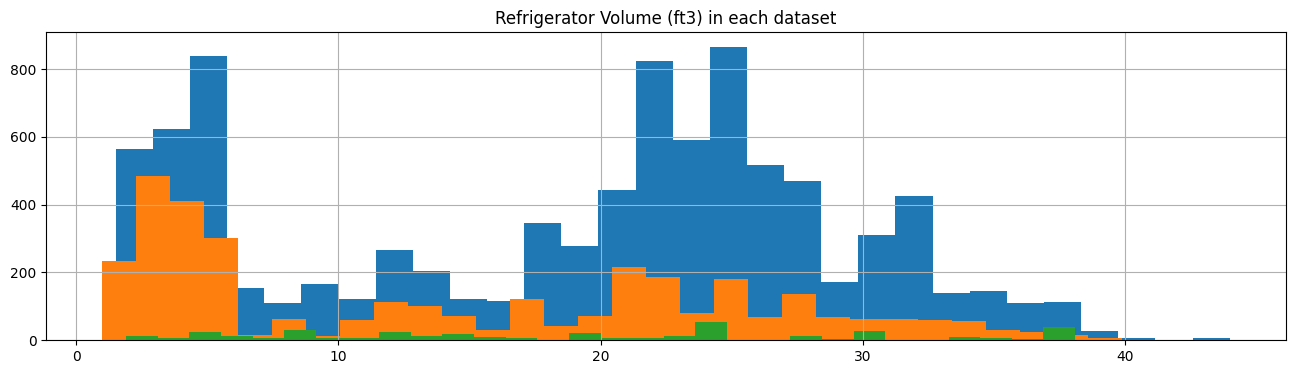

In [76]:
# plot histograms of cubic feet 
display(doe_ref['Total_Adjusted_Volume__Cubic_Feet__d'].hist(bins=30, figsize=(16, 4))) # blue
display(epa_ref['Adjusted Volume (ft3)'].hist(bins=30, figsize=(16, 4))) # orange
display(epa_freeze['Adjusted Volume (ft3)'].hist(bins=30, figsize=(16, 4))) # green


# add title
plt.title('Refrigerator Volume (ft3) in each dataset')

In [77]:
epa_ref['energy_per_volume'] = epa_ref['Annual Energy Use (kWh/yr)'] / epa_ref['Adjusted Volume (ft3)']
epa_freeze['energy_per_volume'] = epa_freeze['Annual Energy Use (kWh/yr)'] / epa_freeze['Adjusted Volume (ft3)']
doe_ref['energy_per_volume'] = doe_ref['Annual_Energy_Use__Kilowatt_Hours_Year__d'] / doe_ref['Total_Adjusted_Volume__Cubic_Feet__d']

<Axes: >

<Axes: >

<Axes: >

Text(0.5, 1.0, 'Energy per Volume (kWh/yr/ft3)')

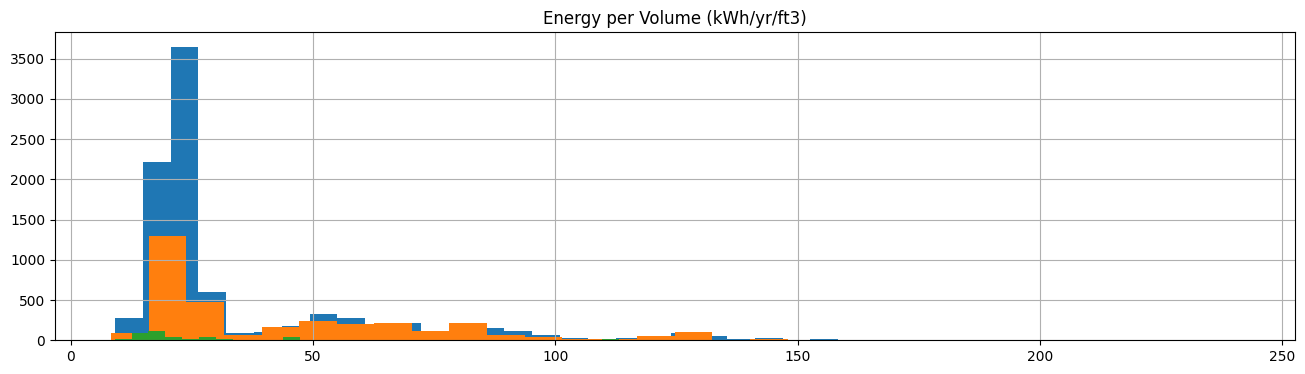

In [78]:
# plot energy_per_volume
display(doe_ref['energy_per_volume'].hist(bins=30, figsize=(16, 4))) # blue
display(epa_ref['energy_per_volume'].hist(bins=30, figsize=(16, 4))) # orange
display(epa_freeze['energy_per_volume'].hist(bins=30, figsize=(16, 4))) # green

# add title
plt.title('Energy per Volume (kWh/yr/ft3)')

# Finding and separating out the overlap in EPA and DOE data

In [79]:
# same as my epa_all above or as Minju's epa_ref_freeze
epa = pd.concat([epa_ref, epa_freeze]).drop_duplicates()\
    .assign(
        code = lambda x: x['Product Class'].str.split(" -").str[0], # since product codes don't exist on epa_freeze, we have to split them out of "Product Class"
        
        # standardize some columns across both datasets
        adj_volume = lambda x: x['Adjusted Volume (ft3)'].astype(float),
        annual_energy_use = lambda x: x['Annual Energy Use (kWh/yr)'].astype(float),
        energy_per_volume = lambda x: x['annual_energy_use'] / x['adj_volume']
    )

epa.sample(3)

,Product Class,Model Number,Annual Energy Use (kWh/yr),Adjusted Volume (ft3),Compact,energy_per_volume,code,adj_volume,annual_energy_use
958,5I - Refrigerator-freezers - automatic defrost...,GDE21EGK****,572,25.5,No,22.431373,5I,25.5,572.0
23,17 - Compact upright freezers with automatic d...,RB36S,300,6.5,Yes,46.153846,17,6.5,300.0
32,9I-BI - Built-In upright freezers with automat...,F9UFESC450PR,452,15.3,No,29.542484,9I-BI,15.3,452.0


In [80]:
doe = doe_ref.assign(
    source='doe',

    # standardize some columns across both datasets
    adj_volume = lambda x: x['Total_Adjusted_Volume__Cubic_Feet__d'].astype(float),
    annual_energy_use = lambda x: x['Annual_Energy_Use__Kilowatt_Hours_Year__d'].astype(float),
    energy_per_volume = lambda x: x['annual_energy_use'] / x['adj_volume']
)

doe.head(3)

,Basic_Model_Number_m,Individual_Model_Number_Covered_by_Basic_Model_m,Annual_Energy_Use__Kilowatt_Hours_Year__d,Total_Adjusted_Volume__Cubic_Feet__d,Product_Group_Code_Description_s,energy_per_volume,source,adj_volume,annual_energy_use
0,HS-60LN(SNZ),ARM17A5ABB,246.0,1.7,(13A.) Compact all-refrigerators - automatic d...,144.705882,doe,1.7,246.0
1,HS-259CN(SNZK),MRC07M7AWW,225.0,12.3,(18.) Compact chest freezers,18.292683,doe,12.3,225.0
2,HS-121LN(S4NZ1),MRM33S9ASL,220.0,3.3,(11A.) Compact all-refrigerators - manual defrost,66.666667,doe,3.3,220.0


We want to dedupe `epa_ref_freeze` and `doe_ref` on their model numbers after replacing `*` and `#` with wildcards on both. We expect doe to be a superset of epa.

In [81]:
# Find all models from the EPA are in the DOE, using REGEX
def regexify_model_number(model_number):
    model_number_regex = re.sub(r'\*', '.', model_number)
    model_number_regex = re.sub(r'\#', '.', model_number_regex)
    return model_number_regex

epa['regexed_model_no'] = epa['Model Number'].apply(regexify_model_number)
doe['regexed_model_no'] = doe['Individual_Model_Number_Covered_by_Basic_Model_m'].apply(regexify_model_number)

Each dataframe now has a `regexed_model_no` column. Here are some models that have wildcards in the model number in both dataframes.

In [82]:
epa_regexes = epa[['regexed_model_no']] 
epa_regexes['source'] = 'epa'
display(epa_regexes.sample(3))

doe_regexes = doe[['regexed_model_no']]
doe_regexes['source'] = 'doe'
display(doe_regexes.sample(3))


,regexed_model_no,source
3421,UC-24R./..,epa
873,FFHT1824US,epa
113,ARW24S1ABB,epa


,regexed_model_no,source
205,316817160,doe
200,VSBS2100EW,doe
2142,WRT318FZD...,doe


now we will make join tables for each

In [83]:
def matches_from_doe(model_number_pattern):
    models = set(doe['Individual_Model_Number_Covered_by_Basic_Model_m'])
    # get all models that match the pattern
    matches = [(str(model_number_pattern), model) for model in models if re.match(model_number_pattern, model)]
    return pd.DataFrame(matches, columns=['epa_regex', 'Individual_Model_Number_Covered_by_Basic_Model_m'])
    
epa_regex_join = pd.concat(epa_regexes.regexed_model_no.progress_apply(matches_from_doe).tolist())
epa_regex_join

  0%|          | 0/3786 [00:00<?, ?it/s]

,epa_regex,Individual_Model_Number_Covered_by_Basic_Model_m
0,AR17T0W,AR17T0W
0,AR17T1B,AR17T1B
0,AR2406W,AR2406W
0,AR24T3S,AR24T3S
0,AR321BB,AR321BB
...,...,...
0,CUF-301BK,CUF-301BK
0,CUF-301SS,CUF-301SS
0,UDF-139SS,UDF-139SS
0,W.FU021A.E.,W*FU021A*E#


In [84]:
def matches_from_epa(model_number_pattern):
    models = set(epa['Model Number'])
    # get all models that match the pattern
    matches = [(str(model_number_pattern), model) for model in models if re.match(model_number_pattern, model)]
    return pd.DataFrame(matches, columns=['doe_regex', 'Model Number'])
    
doe_regex_join = pd.concat(doe_regexes.regexed_model_no.progress_apply(matches_from_epa).tolist())
doe_regex_join

  0%|          | 0/9067 [00:00<?, ?it/s]

,doe_regex,Model Number
0,ARM17A5ABB,ARM17A5ABB
0,MRC07M7AWW,MRC07M7AWW
0,MRM33S9ASL,MRM33S9ASL
0,LMS044M6RBE,LMS044M6RBE
0,7931...,7931***
...,...,...
0,CTMR74C1B,CTMR74C1B
0,VBFR1800ESE-C,VBFR1800ESE-C
0,BCRK43B,BCRK43B
0,BCRK32B,BCRK32B


now if you want all of the items in the epa database that are also in the doe database, you'll want to join through both of these, since you can join by an epa ID matching a doe pattern, or a doe id matching an epa pattern...

In [85]:
# (we think) ...this is assuming our other assumptions about these columns like what they mean, things about duplicates, etc all hold...
# which I have some doubts about...
epa['exists_in_other_db'] = epa.progress_apply(lambda row: 
                                                    row['Model Number'] in doe_regex_join['Model Number'].values or 
                                                    row['regexed_model_no'] in epa_regex_join['epa_regex'].values, 
                                               axis=1)
epa.exists_in_other_db.value_counts()

  0%|          | 0/3786 [00:00<?, ?it/s]

exists_in_other_db
True     2238
False    1548
Name: count, dtype: int64

In [86]:
doe['exists_in_other_db'] = doe.progress_apply(lambda row: 
                                                    row['regexed_model_no'] in doe_regex_join['doe_regex'].values or 
                                                    row['Individual_Model_Number_Covered_by_Basic_Model_m'] in epa_regex_join['Individual_Model_Number_Covered_by_Basic_Model_m'].values,
                                               axis=1)
                                             
doe.exists_in_other_db.value_counts()

  0%|          | 0/9067 [00:00<?, ?it/s]

exists_in_other_db
False    5527
True     3540
Name: count, dtype: int64

# Energy Per Volume Analysis

In [87]:
doe_minus_epa = doe[~doe['exists_in_other_db']]

<Axes: >

<Axes: >

Text(0.5, 1.0, 'Energy per Volume (kWh/yr/ft3)')

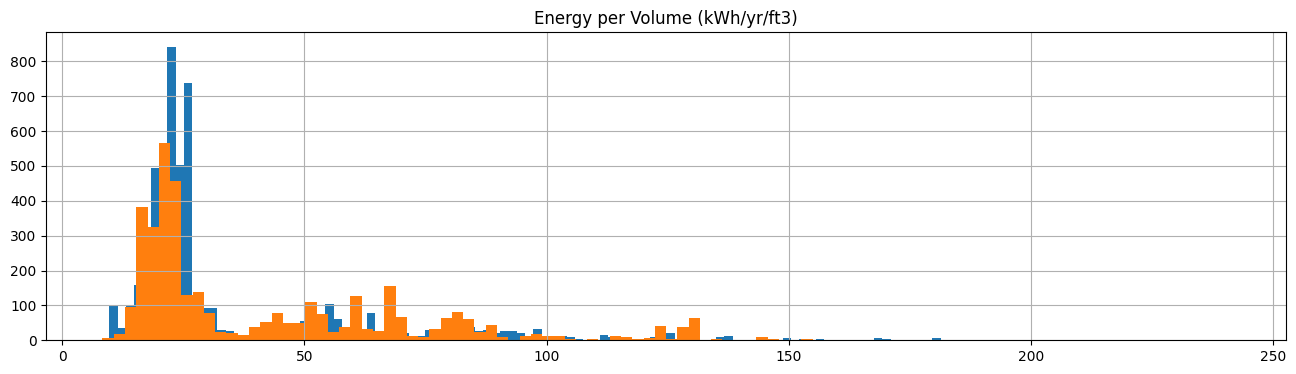

In [88]:
# plot energy_per_volume
display(doe_minus_epa['energy_per_volume'].hist(bins=100, figsize=(16, 4))) # blue
display(epa['energy_per_volume'].hist(bins=100, figsize=(16, 4))) # orange

# add title
plt.title('Energy per Volume (kWh/yr/ft3)')

In [89]:
epa_compact = epa[epa['Compact']=="Yes"]
epa_standard = epa[epa['Compact']=="No"]

In [90]:
doe_mepa_compact = doe_minus_epa[doe_minus_epa['Product_Group_Code_Description_s'].str.lower().str.contains('compact')]
doe_mepa_standard = doe_minus_epa[~doe_minus_epa['Product_Group_Code_Description_s'].str.lower().str.contains('compact')]

In [134]:
print("Percentage of compact refrigerators from ENERGY STAR database:", round(len(epa_compact)/len(epa), 2))
print("Percentage of compact refrigerators from DOE database ", round(len(doe_mepa_compact)/len(doe_minus_epa), 2))

Percentage of compact refrigerators from ENERGY STAR database: 0.43
Percentage of compact refrigerators from DOE database  0.34


In [136]:
print("Percentage of standard refrigerators from ENERGY STAR database:", round(len(epa_standard)/len(epa), 2))
print("Percentage of standard refrigerators from ENERGY STAR database:", round(len(doe_mepa_standard)/len(doe_minus_epa), 2))

Percentage of standard refrigerators from ENERGY STAR database: 0.57
Percentage of standard refrigerators from ENERGY STAR database: 0.66


## ALL

In [93]:
print(f"The average energy per volume for EPA refrigerators is {epa.energy_per_volume.mean():.2f} kWh/yr/ft3")
display(epa.energy_per_volume.describe())

print(f"The average energy per volume for DOE refrigerators is {doe_minus_epa.energy_per_volume.mean():.2f} kWh/yr/ft3")
display(doe_minus_epa.energy_per_volume.describe())

The average energy per volume for EPA refrigerators is 42.67 kWh/yr/ft3


count    3786.000000
mean       42.665545
std        31.309679
min         8.324607
25%        20.391304
50%        24.978632
75%        61.136364
max       241.000000
Name: energy_per_volume, dtype: float64

The average energy per volume for DOE refrigerators is 36.00 kWh/yr/ft3


count    5527.000000
mean       36.003430
std        28.215573
min         9.726027
25%        20.368421
50%        24.349206
75%        39.939124
max       181.333333
Name: energy_per_volume, dtype: float64

<Axes: >

<Axes: >

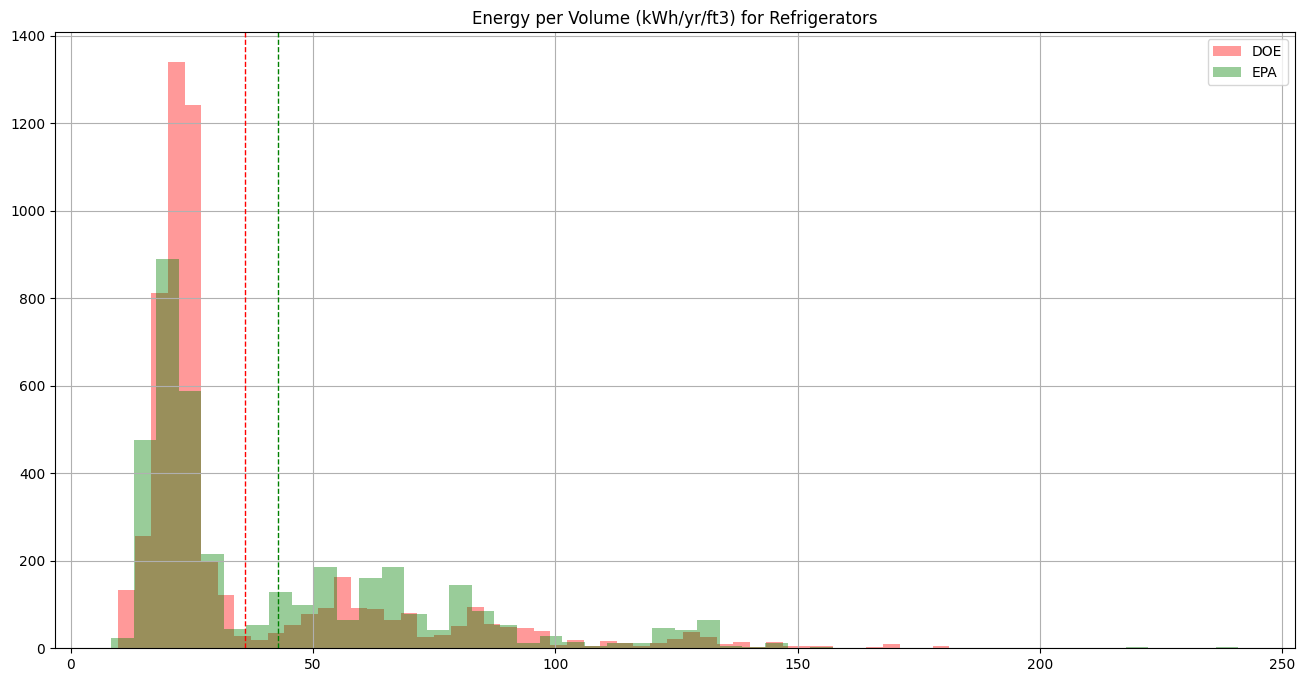

In [94]:
# Plot energy per volume for standard refrigerators
display(doe_minus_epa['energy_per_volume'].hist(bins=50, figsize=(16, 8), color='red', alpha=0.4, label='DOE'))
display(epa['energy_per_volume'].hist(bins=50, figsize=(16, 8), color='green', alpha=0.4, label='EPA'))

# Add title
plt.title('Energy per Volume (kWh/yr/ft3) for Refrigerators')

# Add legend
plt.legend()

# Add average lines
plt.axvline(doe_minus_epa.energy_per_volume.mean(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(epa.energy_per_volume.mean(), color='green', linestyle='dashed', linewidth=1)

In [95]:
more_energy_than_doe_average = epa[epa.energy_per_volume > doe_minus_epa.energy_per_volume.mean()]['Model Number'].count()/epa['Model Number'].count()

print(f"{more_energy_than_doe_average:.2%} of EPA refrigerators use more energy per volume than the average DOE refrigerator.")

41.05% of EPA refrigerators use more energy per volume than the average DOE refrigerator.


## Standard

In [97]:
print(f"The average energy per volume for EPA standard refrigerators is {epa_standard.energy_per_volume.mean():.2f} kWh/yr/ft3")
display(epa_standard.energy_per_volume.describe())

print(f"The average energy per volume for DOE standard refrigerators is {doe_mepa_standard.energy_per_volume.mean():.2f} kWh/yr/ft3")
display(doe_mepa_standard.energy_per_volume.describe())

The average energy per volume for EPA standard refrigerators is 21.38 kWh/yr/ft3


count    2150.000000
mean       21.380316
std         4.859461
min         8.324607
25%        18.111111
50%        21.307096
75%        23.864542
max        80.666667
Name: energy_per_volume, dtype: float64

The average energy per volume for DOE standard refrigerators is 22.46 kWh/yr/ft3


count    3670.000000
mean       22.459583
std         3.837722
min        10.758808
25%        19.323671
50%        22.500000
75%        25.224490
max        49.468085
Name: energy_per_volume, dtype: float64

<Axes: >

<Axes: >

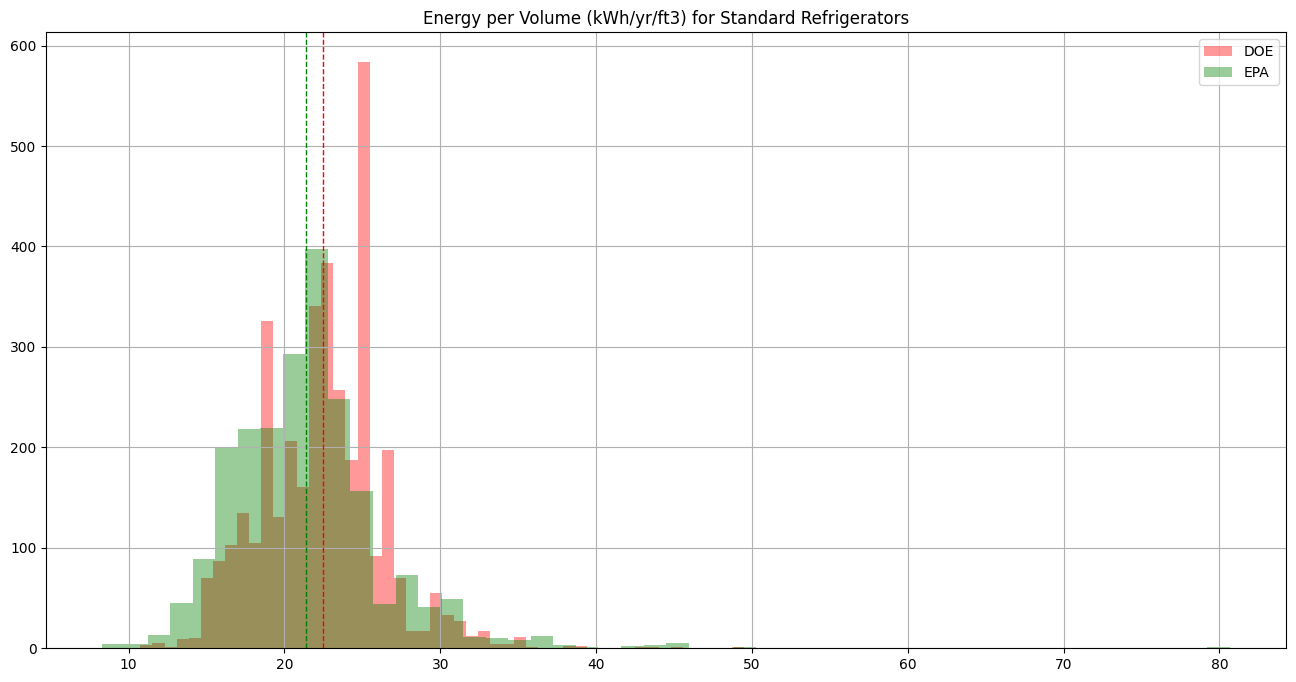

In [98]:
# Plot energy per volume for standard refrigerators
display(doe_mepa_standard['energy_per_volume'].hist(bins=50, figsize=(16, 8), color='red', alpha=0.4, label='DOE'))
display(epa_standard['energy_per_volume'].hist(bins=50, figsize=(16, 8), color='green', alpha=0.4, label='EPA'))

# Add title
plt.title('Energy per Volume (kWh/yr/ft3) for Standard Refrigerators')

# Add legend
plt.legend()

# Add average lines
plt.axvline(doe_mepa_standard.energy_per_volume.mean(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(epa_standard.energy_per_volume.mean(), color='green', linestyle='dashed', linewidth=1)

In [99]:
more_energy_than_doe_average_standard = epa_standard[epa_standard.energy_per_volume > doe_mepa_standard.energy_per_volume.mean()]['Model Number'].count()/epa_standard['Model Number'].count()

print(f"{more_energy_than_doe_average_standard:.2%} of EPA standard refrigerators use more energy per volume than the average DOE standard refrigerator.")

33.26% of EPA standard refrigerators use more energy per volume than the average DOE standard refrigerator.


## Compact

In [100]:
print(f"The average energy per volume for EPA compact refrigerators is {epa_compact.energy_per_volume.mean():.2f} kWh/yr/ft3")
display(epa_compact.energy_per_volume.describe())

print(f"The average energy per volume for DOE compact refrigerators is {doe_mepa_compact.energy_per_volume.mean():.2f} kWh/yr/ft3")
display(doe_mepa_compact.energy_per_volume.describe())

The average energy per volume for EPA compact refrigerators is 70.64 kWh/yr/ft3


count    1636.000000
mean       70.638186
std        29.319220
min        16.097561
25%        51.363636
50%        66.666667
75%        82.692308
max       241.000000
Name: energy_per_volume, dtype: float64

The average energy per volume for DOE compact refrigerators is 62.77 kWh/yr/ft3


count    1857.000000
mean       62.770213
std        35.519822
min         9.726027
25%        34.204545
50%        58.653846
75%        83.548387
max       181.333333
Name: energy_per_volume, dtype: float64

<Axes: >

<Axes: >

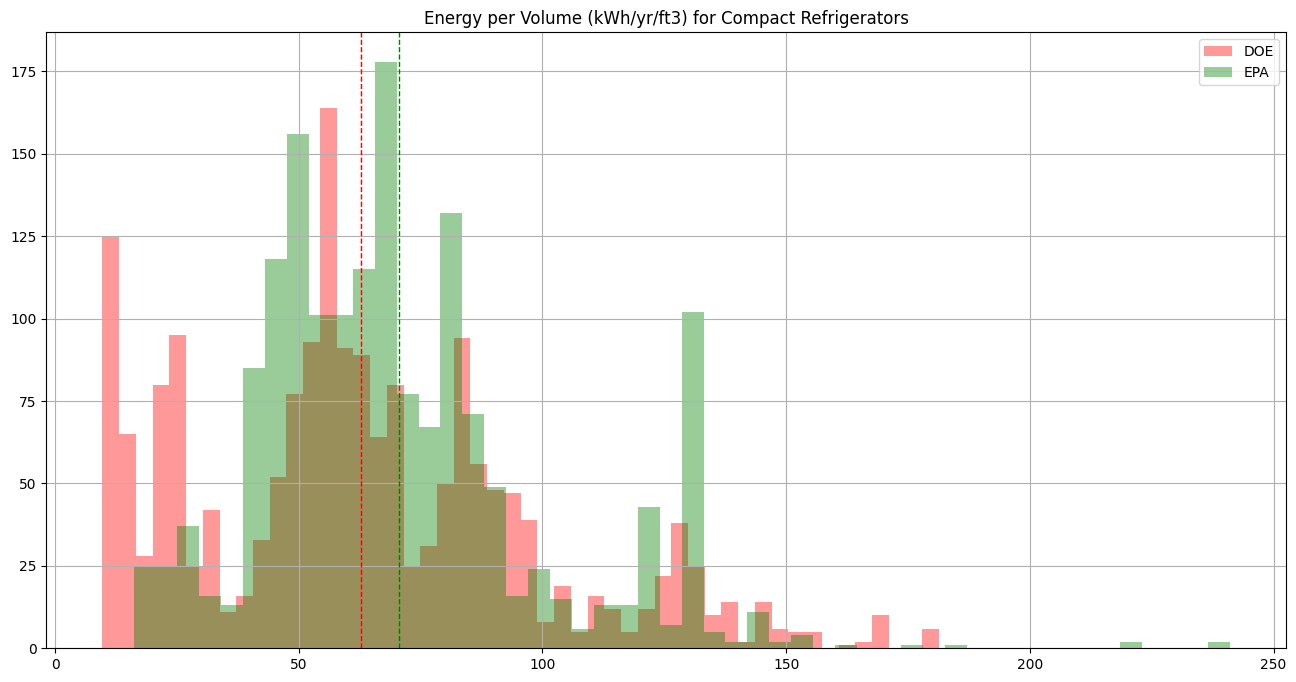

In [101]:
display(doe_mepa_compact['energy_per_volume'].hist(bins=50, figsize=(16, 8), color='red', alpha=0.4, label='DOE'))
display(epa_compact['energy_per_volume'].hist(bins=50, figsize=(16, 8), color='green', alpha=0.4, label='EPA'))


# Add title
plt.title('Energy per Volume (kWh/yr/ft3) for Compact Refrigerators')

# Add legend
plt.legend()

# Add average lines
plt.axvline(doe_mepa_compact.energy_per_volume.mean(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(epa_compact.energy_per_volume.mean(), color='green', linestyle='dashed', linewidth=1)

In [102]:
more_energy_than_doe_average_compact = epa_compact[epa_compact.energy_per_volume > doe_mepa_compact.energy_per_volume.mean()]['Model Number'].count()/epa_compact['Model Number'].count()

print(f"{more_energy_than_doe_average_compact:.2%} of EPA compact refrigerators use more energy per volume than the average DOE compact refrigerator.")

53.42% of EPA compact refrigerators use more energy per volume than the average DOE compact refrigerator.


# Export Analysis Results as CSV

In [107]:
print(len(epa))
print(len(epa_standard))
print(len(epa_compact))
print(len(doe_ref))
print(len(doe_minus_epa))
print(len(doe_mepa_standard))
print(len(doe_mepa_compact))

3786
2150
1636
9067
5527
3670
1857


In [104]:
epa.to_csv('analysis/epa.csv', index=False)
epa_standard.to_csv('analysis/epa_standard.csv', index=False)
epa_compact.to_csv('analysis/epa_compact.csv', index=False)
doe_ref.to_csv('analysis/doe_ref.csv', index=False)
doe_minus_epa.to_csv('analysis/doe_minus_epa.csv', index=False)
doe_mepa_compact.to_csv('analysis/doe_mepa_compact.csv', index=False)
doe_mepa_standard.to_csv('analysis/doe_mepa_standard.csv', index=False)

# Brand Analysis

In [125]:
epa_all = pd.read_csv('epa_residential_refrigerators.csv', dtype={'ENERGY STAR Unique ID': str}).drop_duplicates()
epa_all = epa_all[[
    'Brand Name',
    'Product Class',
    'Model Number',
    'Annual Energy Use (kWh/yr)',
    'Adjusted Volume (ft3)',
    'Compact'
]].drop_duplicates()

In [126]:
epa_all['energy_per_volume'] = epa_all['Annual Energy Use (kWh/yr)'] / epa_all['Adjusted Volume (ft3)']

In [127]:
epa_all.groupby('Brand Name').mean('energy_per_volume').sort_values('energy_per_volume', ascending=False)['energy_per_volume'].reset_index().head(10)

,Brand Name,energy_per_volume
0,ECOFLOW,186.923077
1,Mini Bar,156.871795
2,White-Westinghouse,129.375000
3,RVISION,111.149733
4,DOMETIC,106.799366
5,Danby or Danby Designer,103.929924
6,Willz,103.225806
7,IGLOO,100.355240
8,Antarctic Star,99.218750
9,Lorell,98.402778


In [128]:
epa_all.groupby('Brand Name').mean('energy_per_volume').sort_values('energy_per_volume', ascending=True)['energy_per_volume'].reset_index().head(10)

,Brand Name,energy_per_volume
0,Asko,9.599462
1,Gallery,15.121951
2,True Residential,15.583756
3,CTM,16.086957
4,SANKEY,16.272111
5,Gladiator,16.460674
6,Conservator,16.705643
7,Elisii,16.831513
8,L2,16.860455
9,QG QUALITY GLOBAL,17.203791


In [130]:
(
    epa_all[
        epa_all['Brand Name']
              .str.lower()
              .isin(['samsung', 'lg', 'ge', 'frigidaire', 'whirlpool', 'kenmore'])
    ]
    .groupby('Brand Name')
    .mean('energy_per_volume').sort_values('energy_per_volume', ascending=False).head(10)
)

,Annual Energy Use (kWh/yr),Adjusted Volume (ft3),energy_per_volume
Brand Name,,,
Frigidaire,387.685714,15.598286,51.480984
Kenmore,463.553846,20.330769,35.816890
Whirlpool,464.136842,19.411579,34.460216
GE,505.413333,24.355333,22.177422
LG,584.260870,27.720870,21.609929
Samsung,615.604651,29.672093,21.019838
